# Optimization Task

In [113]:
# Questions:
# - Is the penalty cost incurred every day or only once?
# - What are the penalty costs of an engine that is not maintained at all?

In [114]:
# MY IDEA: define the optimization problem as a permutation
# - change individual to list of engines
# - then it's just a permutation problem
# first few engines are assigned to team 1 until it does not fit anymore
# then, the next few engines are assigned to team 2 until it does not fit anymore etc.

# Population: list of (no_individuals) containing schedules
# Individual: permutation of engines requiring maintenance within the planning horizon.
# Fitness calculation: we go through the permutation. We assign engines to the first team until it does not
#   fit anymore. Then, we go to the next team, assign the engines from the engine where we left of, to the 
#   this next team until it does not fit etc. until we've done all teams. Then, the remaining engines are
#   not maintained, so we just calculate their costs (not sure how high they should be -> see questions above).
#   I think this is an optimal solution as teams A are first, and they're always more efficient than team B.
#   Therefore, moving a team to the next team is always equally or less efficient than assigning it to the
#   current team.

# TODO:
# - experiment with GA instance parameters -> Charlot
# - implement output_format function -> Quintine
# - report: 2.1.2 -> Charlot
# - implement: Run your algorithm 30 times for at most 5 minutes, and plot the average-best-fitness -> Quintine


In [115]:
# Imports
import pandas as pd
import random
import numpy as np
import pygad
import matplotlib.pyplot as plt

In [116]:
# Constants
TOTAL_NO_ENGINES = 100
T_1 = 1

In [117]:
engines = list(range(1, TOTAL_NO_ENGINES + 1))

## Loading Data

In [118]:
file_path = "./data/RUL_consultancy_predictions_A3-2.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the DataFrame to verify that the data was loaded correctly
print(df.head())

RUL = df.iloc[:, 0]
# # Split the "RUL;id" column into two separate columns
# df[['RUL', 'id']] = df['RUL;id'].str.split(';', expand=True)

# # Convert the 'RUL' column to a dictionary with 'id' column as keys
# RUL = dict(zip(df['id'].astype(int), df['RUL'].astype(int)))

   RUL  id
0  135   1
1  125   2
2   63   3
3  100   4
4  103   5


## Maintenance Teams

In [119]:
maintenance_duration = {}

# Define the values for μAj
for engine in engines:
    if 1 <= engine <= 20:
        maintenance_duration[engine] = {'A': 4, 'B': 5}  # since μBj = μAj + 1
    elif 21 <= engine <= 55:
        maintenance_duration[engine] = {'A': 3, 'B': 4}  # since μBj = μAj + 1
    elif 56 <= engine <= 80:
        maintenance_duration[engine] = {'A': 2, 'B': 3}  # since μBj = μAj + 1
    else:
        maintenance_duration[engine] = {'A': 8, 'B': 9}  # since μBj = μAj + 1

# Update the values for μBj based on conditions
for engine in engines:
    if 1 <= engine <= 25:
        maintenance_duration[engine]['B'] = maintenance_duration[engine]['A'] + 1
    elif 26 <= engine <= 70:
        maintenance_duration[engine]['B'] = maintenance_duration[engine]['A'] + 2
    else:
        maintenance_duration[engine]['B'] = maintenance_duration[engine]['A'] + 1

## Safety due date

In [120]:
safety_due_date = {id_val: T_1 + rul - 1 for id_val, rul in RUL.items()}

## Penalty costs

In [121]:
penalty_costs = {}

# Define the values for cj
for engine in range(1, 21):
    penalty_costs[engine] = 4

for engine in range(21, 31):
    penalty_costs[engine] = 3

for engine in range(31, 46):
    penalty_costs[engine] = 2

for engine in range(46, 81):
    penalty_costs[engine] = 5

for engine in range(81, 101):
    penalty_costs[engine] = 6


## Help functions

In [122]:
def cost(engine, day):
    """
    Calculates the incurred cost when an engine is not maintained by its safety due date.

    Parameters:
    - engine: number of the engine
    - day: current day

    Returns:
    - integer: incurred cost for the engine on the day
    """
    if day > safety_due_date[engine]: # Engine is maintained too late
        calculated_cost = penalty_costs[engine] * ((day - safety_due_date[engine]) ** 2)
        return min(calculated_cost, 250)
    else: # Engine is maintained on time
        return 0

In [123]:
def engines_requiring_maintenance(planning_horizon):
    """
    Return the engines that require maintenance within the planning period.

    Parameters:
    - planning_horizon: number of days for which a maintenance schedule needs to be created

    Returns:
    - list: engines requiring maintenance
    """
    engines_to_maintain = []
    for engine_id, due_date in safety_due_date.items():
        if due_date < planning_horizon: # TODO: smaller or smaller equal?
            engines_to_maintain.append(engine_id)
    return engines_to_maintain

In [124]:
def initialize_dataframe():
    """
    Initialize a DataFrame with engine numbers and set all other columns to None.

    Returns:
    - DataFrame: Initialized DataFrame containing engine numbers.
                 Other columns ('team', 'start_date', 'end_date', 'penalty_costs')
                 are set to None.
    """
    # Create DataFrame with "engines" list
    output_df = pd.DataFrame({'engine': engines})

    # Set all other columns to NaN
    output_df['team'] = None
    output_df['start_date'] = None
    output_df['end_date'] = None
    output_df['penalty_costs'] = None

    return output_df

In [125]:
def add_information(dataframe, engine, team_type=None, start_day=None, end_day=None, cost=None):
    """
    Add maintenance information for a specific engine to the DataFrame.

    Parameters:
    - dataframe: The DataFrame containing engine information.
    - engine: The engine number.
    - team_type: The type of team doing the maintenance.
    - start_day: The start date of maintenance.
    - end_day: The end date of maintenance.
    - cost: The penalty costs incurred for maintenance.

    Returns:
    - DataFrame: The DataFrame with updated maintenance information for the specified engine.
    """
    dataframe.loc[dataframe['engine'] == engine, 'team'] = team_type
    dataframe.loc[dataframe['engine'] == engine, 'start_date'] = start_day
    dataframe.loc[dataframe['engine'] == engine, 'end_date'] = end_day
    dataframe.loc[dataframe['engine'] == engine, 'penalty_costs'] = cost

    return dataframe


## 2.1 Genetic Algorithm

In [126]:
# Constants
NO_PARENTS = 100
POPULATION_SIZE = 100
NO_GENERATIONS = 100
MUTATION_PROBABILITY = 0.1 
CROSSOVER_PROBABILITY = 0.9
PARENT_SELECTION_TYPE = "rws"
MUTATION_TYPE = "swap"
ELITISM = 1

PLANNING_HORIZON = 30
NO_TEAMS = 4
TEAM_TYPES = ["A", "A", "B", "B"] # List indicating which type each team has (i.e. "A" or "B")
MAX_DURATION = 5 * 60  # 5 minutes in seconds
PENALTY_VALUE = 1e9
ENGINES_TO_MAINTAIN = engines_requiring_maintenance(PLANNING_HORIZON)
NO_ENGINES = len(ENGINES_TO_MAINTAIN)

import math
print('Number of possible individuals', math.factorial(NO_ENGINES))

Number of possible individuals 620448401733239439360000


In [127]:
def create_initial_population():
    """
    Creates a certain number of random individuals (i.e., maintenance schedules).
    Each individual is a permutation of the list of engines requiring maintenance.

    Returns:
    - numpy array: Population containing the random individuals (i.e., maintenance schedules).
    """
    population = np.zeros((POPULATION_SIZE, NO_ENGINES))

    # Iterate to create a certain number of individuals in the population
    for individual in range(POPULATION_SIZE):
        # Each individual is a random permutation of the list of engines requiring maintenance.
        population[individual] = ENGINES_TO_MAINTAIN.copy()
        random.shuffle(population[individual])

    return population

In [128]:
def fitness_func(ga_instance, schedule, schedule_idx):
    """
    Calculate the fitness value (i.e., total incurred costs) for a given solution.

    Args:
    - ga_instance: Instance of the GA class (required argument).
    - schedule (numpy.ndarray): Solution representing a maintenance schedule.
    - schedule_idx (int): Index of the schedule (i.e., individual) in the population (required argument).

    Returns:
    - float: Total incurred costs for the given schedule.
    """
    total_costs = 0 # Initialize total costs counter
    engine_idx = 0 # Start with the first engine in the schedule

    # Iterate through the teams
    for team in range(NO_TEAMS):
        team_type = TEAM_TYPES[team]  # Get the type of the current team (i.e., "A" or "B")
        day = T_1 # Start on the first day of the team
        
        # Assign engines to this team until the team's schedule is full or there are no engines left
        while day <= PLANNING_HORIZON and engine_idx < len(schedule):
            engine = schedule[engine_idx] # Number of the engine
            no_days = maintenance_duration[engine][team_type] # Number of days it takes to maintain the engine

            if day + no_days <= PLANNING_HORIZON: # Engine fits in team's schedule
                total_costs += cost(engine, day)  # Add the incurred costs of the engine
                day += no_days # Increase day counter
                engine_idx += 1 # Go to next engine in the schedule
            else: # Engine does not fit
                break # Go to the next team

    day = PLANNING_HORIZON

    # Add costs for engines that could not be scheduled within the available days of any team
    while engine_idx < len(schedule):
        engine = schedule[engine_idx] # Number of the engine
        # total_costs += cost(engine, PLANNING_HORIZON) # Add the incurred costs of the engine
        total_costs += 250 # TODO: choose
        engine_idx += 1 # Go to next engine in the schedule

    return total_costs
    

In [129]:
def order_crossover(parents, offspring_size, ga_instance):
    """
    Perform order crossover on the parents to generate offspring.

    Args:
    - parents (numpy.ndarray): Parent solutions for crossover.
    - offspring_size (tuple): Size of the offspring population.
    - ga_instance (pygad.GA): Instance of the GA class (required argument).

    Returns:
    - numpy.ndarray: Offspring population generated by order crossover.
    """
    offspring = []

    while len(offspring) < offspring_size[0]:
        # Generate two unique random indices for selecting parents
        idx1, idx2 = np.random.choice(len(parents), size=2, replace=False)

        # Select parents using the generated indices
        parent1 = parents[idx1, :].copy()
        parent2 = parents[idx2, :].copy()

        # Randomly select two crossover points
        crossover_points = np.random.choice(len(parent1), size=2, replace=False)
        crossover_point1, crossover_point2 = np.sort(crossover_points)

        # Create a copy of parents to store the offspring
        child1 = np.zeros(len(parent1))
        child2 = np.zeros(len(parent2))

        # Extract the gene segments from both parents
        segment_from_parent1 = parent1[crossover_point1:crossover_point2]
        segment_from_parent2 = parent2[crossover_point1:crossover_point2]
        
        # Transfer the gene segments to the offspring
        child1[crossover_point1:crossover_point2] = segment_from_parent2
        child2[crossover_point1:crossover_point2] = segment_from_parent1

        # Find the missing values in child1
        missing_values1 = [gene for gene in parent1 if gene not in segment_from_parent2]

        # Find the missing values in offspring2
        missing_values2 = [gene for gene in parent2 if gene not in segment_from_parent1]

        # Insert missing values into child1 at the correct positions
        idx1 = 0
        for i in range(len(child1)):
            if child1[i] == 0:
                child1[i] = missing_values1[idx1]
                idx1 += 1

        offspring.append(child1) # Add first child to offspring

        if len(offspring) >= offspring_size[0]: # Enough children have been created
            break

        # Insert missing values into child2 at the correct positions
        idx2 = 0
        for i in range(len(child2)):
            if child2[i] == 0:
                child2[i] = missing_values2[idx2]
                idx2 += 1
        
        offspring.append(child2) # Add second child to offspring
        
    return np.array(offspring) # Numpy array is the required format for the offspring

In [135]:
def create_instance():
    """
    Create and initialize a GA instance with specified parameters.
    
    Returns:
    - pygad.GA: Initialized GA instance.
    """
    # Initialize the GA instance
    ga_instance = pygad.GA(num_generations=NO_GENERATIONS,
                           num_parents_mating=NO_PARENTS,
                           fitness_func=fitness_func,  # Our custom fitness evaluation function
                           sol_per_pop=POPULATION_SIZE,
                           parent_selection_type=PARENT_SELECTION_TYPE,  # Roulette Wheel Selection with Rank-Based Fitness Values
                           crossover_type=order_crossover,  # Our custom order crossover function
                           mutation_type=MUTATION_TYPE,  # Use swap mutation to prevent duplicate engines in the schedules
                           keep_elitism=ELITISM,  # Number of best solutions that are copied to the next generation
                           mutation_probability=MUTATION_PROBABILITY,
                           crossover_probability=CROSSOVER_PROBABILITY,
                           initial_population=create_initial_population(),  # Our custom create initial population function
                           num_genes=NO_ENGINES
                           )
    return ga_instance

### Transform to correct output format

In [131]:
def output_format(solution):
    """
    Transform solution to the correct output format.

    Parameters:
    - solution: Permutation of machines maintained.

    Returns:
    - list: all machines, indicating for any maintained machine the type of
    the team doing the maintenance, start-date, and end-date of the maintenance, 
    as well as the penalty costs incurred by that machine
    """
    output_df = initialize_dataframe()
    engine_idx = 0 # Start with the first engine in the solution

    # Iterate through the teams
    for team in range(NO_TEAMS):
        team_type = TEAM_TYPES[team]  # Get the type of the current team (i.e., "A" or "B")
        day = T_1 # Start on the first day of the team
        
        # Assign engines to this team until the team's schedule is full or there are no engines left
        while day <= PLANNING_HORIZON and engine_idx < len(solution):
            engine = solution[engine_idx] # Number of the engine
            no_days = maintenance_duration[engine][team_type] # Number of days it takes to maintain the engine

            if day + no_days <= PLANNING_HORIZON: # Engine fits in team's schedule
                incurred_cost = cost(engine, day) # Incurred cost of the engine
                output_df = add_information(output_df, engine, team_type, day, day + no_days, incurred_cost)
                day += no_days # Increase day counter
                engine_idx += 1 # Go to next engine in the schedule
            else: # Engine does not fit
                break # Go to the next team

    # Add costs for engines that could not be scheduled within the available days of any team
    while engine_idx < len(solution):
        engine = solution[engine_idx] # Number of the engine
        # incurred_cost += cost(engine, PLANNING_HORIZON) # Add the incurred costs of the engine
        incurred_cost = 250 # TODO: choose
        output_df = add_information(output_df, engine, cost=incurred_cost)
        engine_idx += 1 # Go to next engine in the schedule

    return output_df

## 2.2 Optimization

### Best found solution (runtime of max. 5 minutes)

In [138]:
# Run the GA instance for a specified number of generations
ga_instance = create_instance()
ga_instance.run()

# Retrieve the best solution found so far
solution, solution_fitness, _ = ga_instance.best_solution()

/home/quintine/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [139]:
# Print or use the best solution
print("Best solution:\n", output_format(solution))
print("Best solution fitness:", solution_fitness)

Best solution:
     engine  team start_date end_date penalty_costs
0        1  None       None     None          None
1        2  None       None     None          None
2        3  None       None     None          None
3        4  None       None     None          None
4        5  None       None     None          None
..     ...   ...        ...      ...           ...
95      96  None       None     None          None
96      97  None       None     None          None
97      98  None       None     None          None
98      99     A         11       19             0
99     100  None       None     None          None

[100 rows x 5 columns]
Best solution fitness: 2424


### Average-best-fitness (run 30 times for max. 5 minutes)

/home/quintine/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


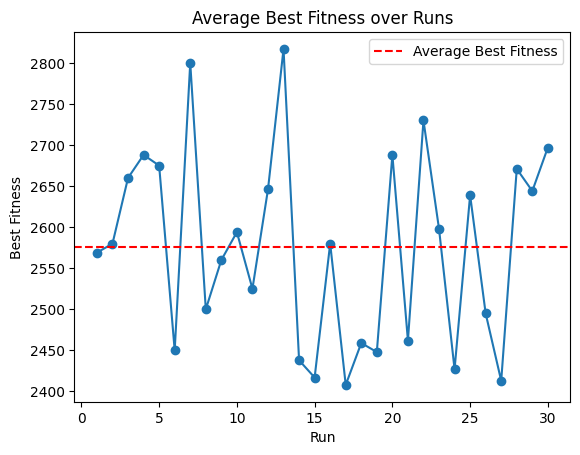

Average Best Fitness over 30 runs: 2575.9333333333334


In [140]:
# Number of runs
num_runs = 30

# Initialize an empty list to store the best fitness values
best_fitness_values = []

for _ in range(num_runs):
    # Run a GA instance for a specified number of generations
    ga_instance = create_instance()
    ga_instance.run()

    # Retrieve the best solution found so far
    _, solution_fitness, _ = ga_instance.best_solution()

    # Append the best fitness value to the list
    best_fitness_values.append(solution_fitness)

# Calculate the average best fitness value
average_best_fitness = np.mean(best_fitness_values)

# Plot the average best fitness value
plt.plot(range(1, num_runs + 1), best_fitness_values, marker='o')
plt.axhline(y=average_best_fitness, color='r', linestyle='--', label='Average Best Fitness')
plt.xlabel('Run')
plt.ylabel('Best Fitness')
plt.title('Average Best Fitness over Runs')
plt.legend()
plt.show()

# Print the average best fitness value
print("Average Best Fitness over", num_runs, "runs:", average_best_fitness)